# Create emulator (neural network) 

## Import modules

In [2]:
#From our previous codes
%matplotlib inline
import xarray as xr
import glob
import os
import matplotlib.pyplot as plt
import pandas.plotting
import numpy as np
from mpl_toolkits.basemap import Basemap
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
import matplotlib.ticker as ticker

#From Katie's code
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras.regularizers import l2

import keras.backend as K

from scipy import stats

Using TensorFlow backend.


## Read the simulations.csv file and create inputdata array

In [12]:
# Read data from file 'simulations.csv' 
# Then arrange ncely the data in dataframe and change data type of the values
data = pd.read_csv("./simulations.csv", header=None)
#d=data.reset_index()

line0 = data.iloc[0,0]

param_names=[21]

param_names[0] = 'RKDN'
param_names[1:] = re.findall( r'( .*?)=', line0)
param_values = re.findall( r'=(.*?\d.*?e.*?0\d)', line0)
[float(param_values[k]) for k in range(len(param_values)-1)]

df_params = pd.DataFrame(param_values, index=param_names)
df_params[0] = df_params[0].astype(float)

i=1
while i<199:
    line = data.iloc[i,0]
    param_values2 = re.findall( r'=(.*?\d.*?e.*?0\d)', line)
    [float(param_values2[l]) for l in range(len(param_values2)-1)]
    df_params[str(i)]=(param_values2)
    df_params[str(i)] = df_params[str(i)].astype(float)
    i = i+1


inputdata = df_params.transpose()     #.reset_index()    #   
inputdata

# Save the numpy array in a file   
inp=inputdata.values
np.save('/data/home/globc/peatier/CNRMppe/inputdata_file.npy', inp)

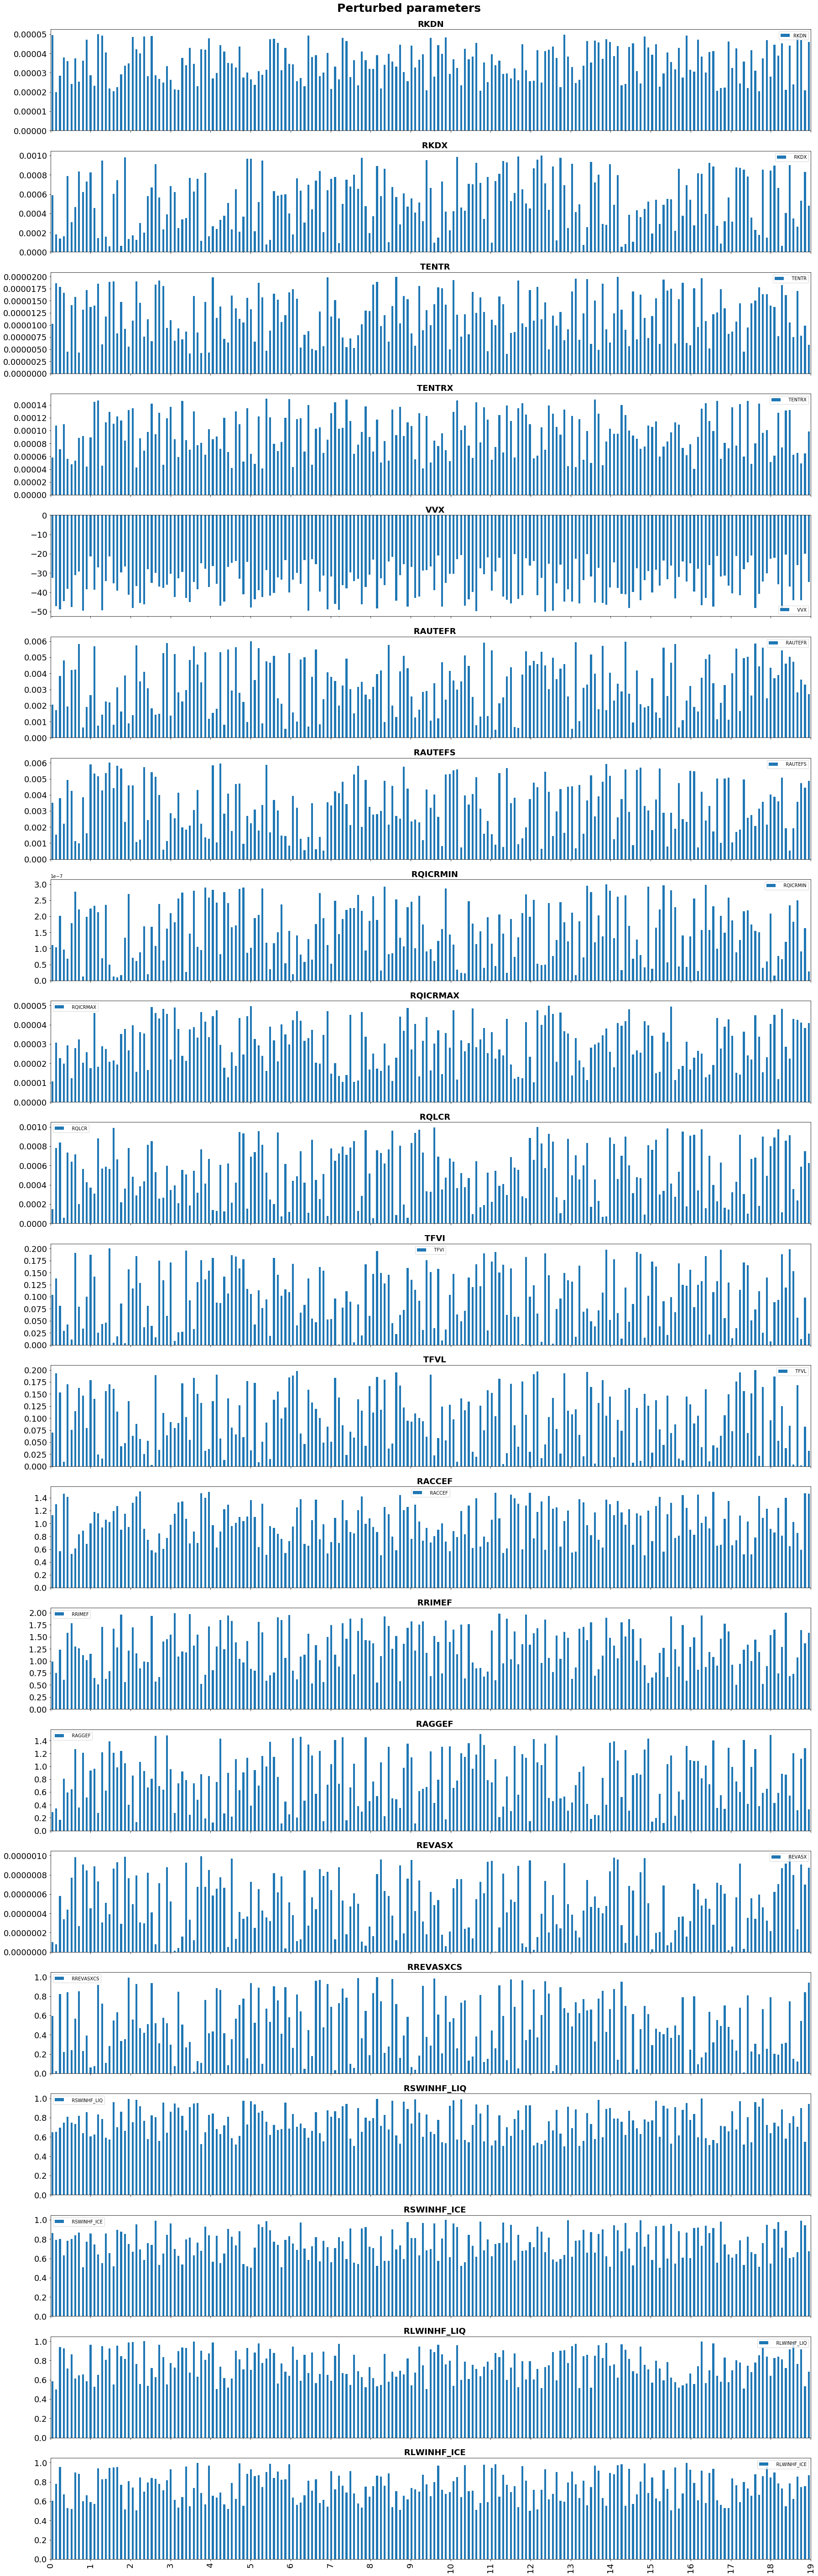

In [82]:
#Create plot

#fig = plt.gca()

#inputdata.plot(kind='bar',y='RKDN')
#plt.show()

fig_params=plt.figure(figsize=(25, 80))
#Xaxis=np.arange(0,210,10)
#print(Xaxis)

# boucle pour céer les figures:
i=0
p=1
while i < 21:
    ax = fig_params.add_subplot(21,1,p)
    param=param_names[i]
    ax.set_title(param, fontsize=18, fontweight='bold')
    inputdata.plot(kind='bar',y=param, ax=ax, fontsize=18, sharex=True)
    ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=20))
    i = i+1
    p = p+1

fig_params.suptitle('Perturbed parameters', fontsize=25, fontweight = 'bold')
fig_params.tight_layout()
fig_params.subplots_adjust(top=0.97,hspace = 0.2)

## Read /PRE623TUN*.nc and create outputdata array

In [18]:
# -------------------------------------  Simulations :  -----------------------------------------------------
path_simul = "/scratch/globc/dcom/ARPEGE6_TUNE"
filename_simul = "/PRE623TUN*.nc"
file_simul = xr.open_mfdataset(path_simul+filename_simul,concat_dim='ensemble',combine='nested')

# TOA fluxes
var = ['rsut','rlut']
nc_simul = file_simul[var]
# compute global mean... WARNING : no scale factors used here !
xarray_simul = nc_simul.mean('lat').mean('lon')
simul = xarray_simul.to_dataframe()
simul

/scratch/globc/peatier/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/globc/peatier/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/globc/peatier/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/globc/peatier/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


rsut        rlut
ensemble time                              
0        2005-01-16  113.273178  227.874329
         2005-02-15  101.699585  225.817368
         2005-03-17   90.496605  223.946503
         2005-04-16   93.339607  226.180756
         2005-05-17  100.723251  228.881042
...                         ...         ...
195      2014-08-17   92.173386  227.103821
         2014-09-16   86.494080  223.982697
         2014-10-17   95.541801  222.299500
         2014-11-16  111.119034  220.234360
         2014-12-17  118.969276  220.970535

[23520 rows x 2 columns]

In [19]:
# Compute climatology
sim = simul.reset_index(level=['time'])
sim['month'] = pd.DatetimeIndex(sim['time']).month
outputdata=sim.groupby(['ensemble','month']).mean()
outputdata

rsut        rlut
ensemble month                        
0        1      113.758476  226.931229
         2      101.597633  225.027222
         3       90.300560  224.130585
         4       93.793381  224.972534
         5      101.232162  228.375397
...                    ...         ...
195      8       92.153152  226.599136
         9       86.344009  223.742706
         10      95.454201  221.000275
         11     111.443703  220.210449
         12     119.818794  220.522064

[2352 rows x 2 columns]

In [20]:
# Save the numpy array in a file   
out=outputdata.values
np.save('/data/home/globc/peatier/CNRMppe/outputdata_file.npy', out)

## Create Emulator

In [21]:
# Read in input array
inputdata = np.load(file="inputdata_file.npy")

# List of input variables
in_vars = param_names

# Read in outputdata array
outputdata = np.load("outputdata_file.npy")

# Create 2-layer simple model
model = Sequential()
# first layer with 20 nodes and rectified linear activation
# specify input_dim as number of parameters, not number of simulations
# l2 norm regularizer
model.add(Dense(20, input_dim=inputdata.shape[1], activation='relu',
    kernel_regularizer=l2(.001)))
# output layer with linear activation
model.add(Dense(1))

# Define model metrics
def mean_error(y_true,y_pred):
    return K.mean(y_true-y_pred)

# Compile model
#model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
#model.compile(optimizer='adam',loss='mse',metrics=[mean_pred])
# using a stochastic gradient descent optimizer
opt_dense = SGD(lr=0.001, momentum=0.99, decay=1e-4, nesterov=True)
model.compile(opt_dense, "mse", metrics=[mean_error])
#model.summary()

# Separate training/test data: 60/40 split
# how does test split into validation/verification? try 20/20
x_train = inputdata[0:60,:]
x_test = inputdata[60:,:]
#x_val = inputdata[80:,:]
y_train = outputdata[0:60]
y_test = outputdata[60:]
#y_val = outputdata[80:]

# Fit the model
#model.fit(x_train, y_train, epochs=20, batch_size=10)
#model.fit(x_train, y_train, epochs=40, batch_size=10)
#print(model)
results = model.fit(x_train, y_train, epochs=150, batch_size=30,
        validation_data=(x_test,y_test))

#print(results.history)
print("Training Mean Error:", results.history['mean_error'][-1])
print("Validation Mean Error:", results.history['val_mean_error'][-1])

# Plot histogram of model mean error
plt.hist(results.history['mean_error'], bins=20)
plt.xlabel('Training Mean Error')
plt.ylabel('Counts')
#plt.savefig("dist_train_me.eps")
plt.show()

# Plot histogram of validation mean error
plt.hist(results.history['val_mean_error'], bins=20)
plt.xlabel('Validation Mean Error')
plt.ylabel('Counts')
#plt.savefig("dist_val_me.eps")
plt.show()

ValueError: Error when checking target: expected dense_6 to have shape (1,) but got array with shape (2,)

In [ ]:
# Plot training history by epoch
#plt.plot(results.epoch, results.history['val_mean_error'], label='validation')
#plt.plot(results.epoch, results.history['mean_error'], label='train')
##plt.xticks(results.epoch)
#plt.legend()
#plt.hlines(y=0,xmin=0,xmax=150)
#plt.ylabel('Mean Error')
#plt.xlabel('Epoch')
#plt.title('Neural Network Training History')
#plt.savefig("train_history.eps")
#plt.show()

# Evaluate the model using test data
#score = model.evaluate(x_test, y_test, batch_size=10)
#print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
#print(score)

# Make predictions - using validation subsection?
#predictions = model.predict(inputdata)
#predictions = model.predict(x_val)
#print(predictions)
#model_preds = model.predict(x_test)[:,0]

# model metric for predictions
#def model_error_preds(y_true,y_pred):
#    return np.mean(y_true-y_pred)

# calculate model mean error with predictions
#model_me = model_error_preds(y_test, model_preds)
#print("Prediction Mean Error: ", model_me)

# plot histogram of prediction error
#plt.hist(y_test-model_preds, bins=10)
#plt.xlabel('Prediction Error')
#plt.ylabel('Counts')
#plt.savefig("dist_preds.eps")
#plt.show()

# scatterplot actual versus predicted (validation set)
#plt.scatter(y_test, model_preds)
#plt.xlabel('Model Output GPP')
#plt.ylabel('Predicted GPP')
#plt.xlim(1.7,2.7)
#plt.ylim(1.7,2.7)
# trying to get a 1:1 line to show up (doesn't work)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
#plt.savefig("validation_scatter.eps")
#plt.show()

# linear regression of actual vs predicted
#slope, intercept, r_value, p_value, std_err = stats.linregress(y_test,
#                model_preds)
#print("r-squared:", r_value**2)

# Model interpretation by permutation variable importance
#def variable_importance(model, data, labels, input_vars, score_func, num_iters=10):
#    preds = model.predict(data)[:, 0]
#    score_val = score_func(labels, preds)
#    indices = np.arange(data.shape[0])
#    imp_scores = np.zeros((len(input_vars), num_iters))
#    shuf_data = np.copy(data)
#    for n in range(num_iters):
#        print(n)
#        np.random.shuffle(indices)
#        for v, var in enumerate(input_vars):
#            print(var)
#            shuf_data[:, v] = shuf_data[indices, v]
#            shuf_preds = model.predict(shuf_data)[:, 0]
#            imp_scores[v, n] = score_func(labels, shuf_preds)
#            shuf_data[:, v] = data[:, v]
#    return score_val - imp_scores

#model_imp_scores = variable_importance(model, x_test, y_test, in_vars,
#        model_error_preds, num_iters=3)
#model_mean_scores = model_imp_scores.mean(axis=1)
#for v, var in enumerate(in_vars):
#    print(var, model_mean_scores[v])

# Visualize what input most activates the output layer through feature
# optimization
#out_diff = K.mean((model.layers[-1].output - 1) ** 2)
#grad = K.gradients(out_diff, [model.input])[0]
#grad /= K.maximum(K.sqrt(K.mean(grad ** 2)), K.epsilon())
#iterate = K.function([model.input, K.learning_phase()],
#        [out_diff, grad])
#input_img_data = np.zeros(shape=(1, len(in_vars)))
#print(input_img_data.shape)

#for i in range(20):
#    out_loss, out_grad = iterate([input_img_data, 0])
#    input_img_data -= out_grad * 0.1
#    print(out_loss, out_grad.max())

# Plot the output layer feature optimization
#not working right now - input data is wrong size 
#plt.pcolormesh(input_img_data[0,0] * scaling_values.loc[0,"std"] +
#        scaling_values.loc[0,"mean"], vmin=-10, vmax=80,
#        cmap="gist_ncar")
#plt.colorbar()
#plt.quiver(input_img_data[0,-2]*scaling_values.loc[1,"std"] + 
#        scaling_values.loc[1,"mean"], 
#        input_img_data[0,-1]*scaling_values.loc[2,"std"] + 
#        scaling_values.loc[2,"mean"], scale=500)
#plt.title("Neural Net Output Layer Feature Optimization")
#plt.show()

#plt.pcolormesh(input_img_data[0,0], vmin=-5, vmax=5, cmap="RdBu_r")
#plt.quiver(input_img_data[0,1], input_img_data[0,2], scale=100)
#plt.show()

# Visualize the distribution of model weights in the output layer
#plt.hist(model.layers[-2].get_weights()[0], bins=50)
#plt.xlabel("Neural Net Output Layer Weights")
#plt.ylabel("Counts")
#plt.show()